https://towardsdatascience.com/time-series-in-python-exponential-smoothing-and-arima-processes-2c67f2a52788

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np



# Stationarity

In [3]:
airpassengers = pd.read_csv('./datasets/AirPassengers.csv')

airpassengers_ts = pd.Series(airpassengers['#Passengers'].values, 
                            index = pd.date_range('1949-01', periods = len(airpassengers), freq='M'))

Text(0.5, 1.0, 'airpassengers')

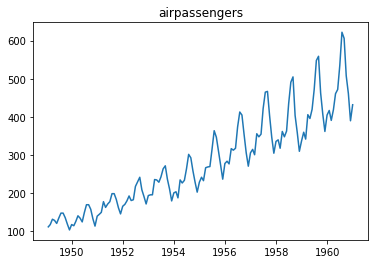

In [4]:
plt.plot(airpassengers_ts)
plt.title('airpassengers')

There are many techniques (logarithm, exponential, de-trending, differencing) can be use to transform non-stationary series into stationary.

what technique to use depend on the pattern of our time series

Since we has a series with increment variance, logarithm transformation can be use to smooth out the variance.

In [5]:
airpassengers_log = np.log(airpassengers_ts)

Text(0.5, 1.0, 'log transformation')

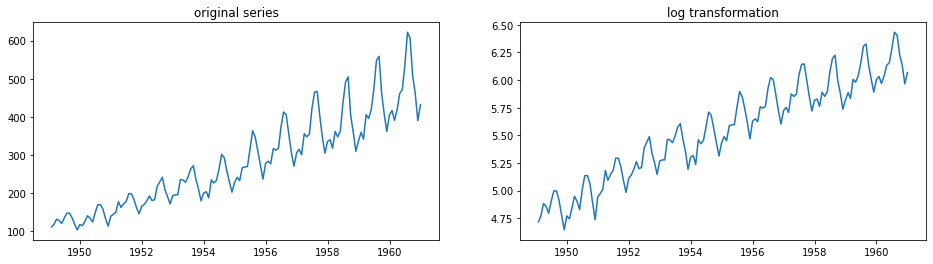

In [6]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 4))

ax1.plot(airpassengers_ts)
ax1.set_title('original series')

ax2.plot(airpassengers_log)
ax2.set_title('log transformation')

differencing

In [294]:
airpassengers_diff = airpassengers_log.diff()

Text(0.5, 1.0, 'differencing')

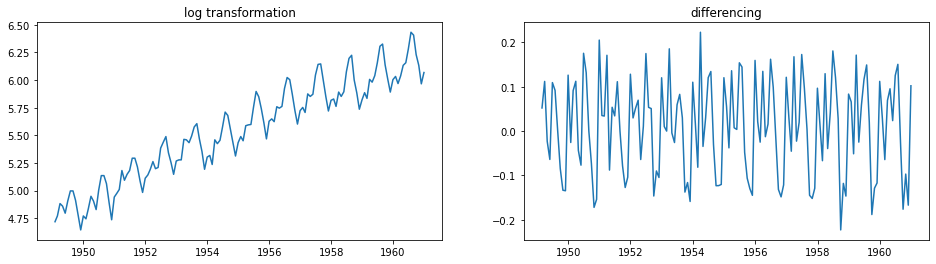

In [8]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 4))

ax1.plot(airpassengers_log)
ax1.set_title('log transformation')

ax2.plot(airpassengers_diff)
ax2.set_title('differencing')

### Stationarity Check

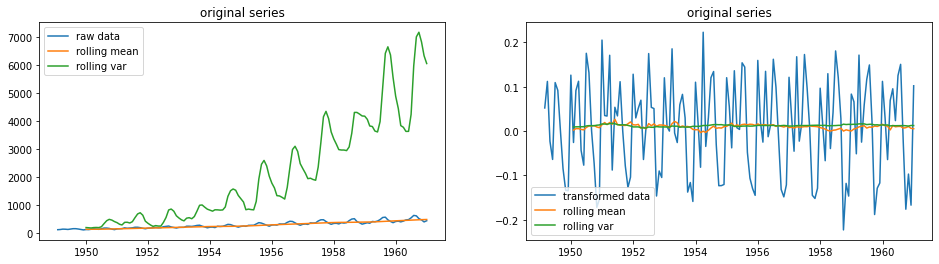

In [9]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 4))

ax1.plot(airpassengers_ts, label = 'raw data')
ax1.plot(airpassengers_ts.rolling(window=12).mean(), label="rolling mean");
ax1.plot(airpassengers_ts.rolling(window=12).var(), label="rolling var");
ax1.set_title('original series')
ax1.legend()

ax2.plot(airpassengers_diff, label = 'transformed data')
ax2.plot(airpassengers_diff.rolling(window=12).mean(), label="rolling mean");
ax2.plot(airpassengers_diff.rolling(window=12).var(), label="rolling var");
ax2.set_title('original series')
ax2.legend()

#### Augmented Dickey-Fuller Test (ADF)

ADF is a type of unit root test. Unit roots are a cause for non-stationarity, the ADF test will test if unit root is present.

A time series is stationary if a single shift in time doesn’t change the time series statistical properties, in which case unit root does not exist.

The Null and Alternate hypothesis of the Augmented Dickey-Fuller test is defined as follows:
- Null Hypothesis states there is the presence of a unit root.
- Alternate Hypothesis states there is no unit root. In other words, Stationarity exists.


The null hypothesis of the Augmented Dickey-Fuller is that there is a unit
root, with the alternative that there is no unit root. If the pvalue is
above a critical size, then we cannot reject that there is a unit root.

https://machinelearningmastery.com/time-series-data-stationary-python/

http://www.insightsbot.com/augmented-dickey-fuller-test-in-python/

In [10]:
def print_adf_result(adf_result):
    df_results = pd.Series(adf_result[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])
    
    for key, value in adf_result[4].items():
        df_results['Critical Value (%s)'% key] = value
    print('Augmented Dickey-Fuller Test Results:')
    print(df_results)

In [11]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(airpassengers_ts, maxlag=12)
print_adf_result(result)

Augmented Dickey-Fuller Test Results:
ADF Test Statistic        1.564685
P-Value                   0.997748
# Lags Used              12.000000
# Observations Used     131.000000
Critical Value (1%)      -3.481282
Critical Value (5%)      -2.883868
Critical Value (10%)     -2.578677
dtype: float64


In [12]:
result = adfuller(airpassengers_diff[1:], maxlag=12)
print_adf_result(result)

Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -3.053032
P-Value                   0.030230
# Lags Used              12.000000
# Observations Used     130.000000
Critical Value (1%)      -3.481682
Critical Value (5%)      -2.884042
Critical Value (10%)     -2.578770
dtype: float64


#### Test Stationary using Autocorrelation Function (ACF)

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

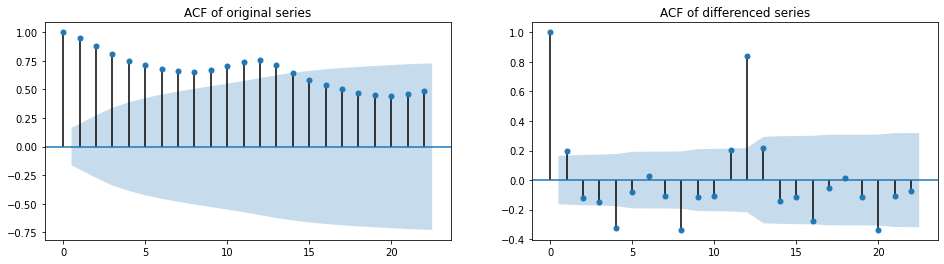

In [235]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 4))

plot_acf(airpassengers_ts, ax1)
ax1.set_title('ACF of original series')

plot_acf(airpassengers_diff[1:], ax2)
ax2.set_title('ACF of differenced series')

plt.show()

### Simple Forecasting

In [322]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

airpassengers_ts_train = airpassengers_ts[:-24]
airpassengers_ts_test = airpassengers_ts[-24:]

airpassengers_log_train = airpassengers_log[:-24]
airpassengers_log_test = airpassengers_log[-24:]

airpassengers_diff_train = airpassengers_diff[:-24]
airpassengers_diff_test = airpassengers_diff[-24:]

ses = SimpleExpSmoothing(airpassengers_diff_train[1:])
ses = ses.fit()

ses_forecast = ses.forecast(24)

Text(0.5, 1.0, 'forecast for next 24 month')

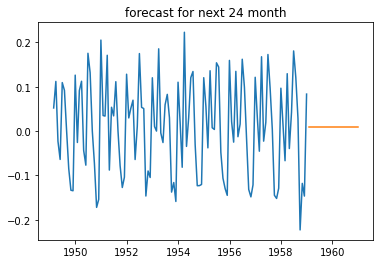

In [323]:
plt.plot(airpassengers_diff_train)
plt.plot(ses_forecast)
plt.title('forecast for next 24 month')

inverse differencing

In [324]:
ses_forecast[0] = ses_forecast[0] + airpassengers_log_train[-1]
ses_forecast_inv_diff = ses_forecast.cumsum()

inverse log transformation

In [325]:
ses_forecast_inv_log = np.exp(ses_forecast_inv_diff)

Text(0.5, 1.0, 'inverse log transformation')

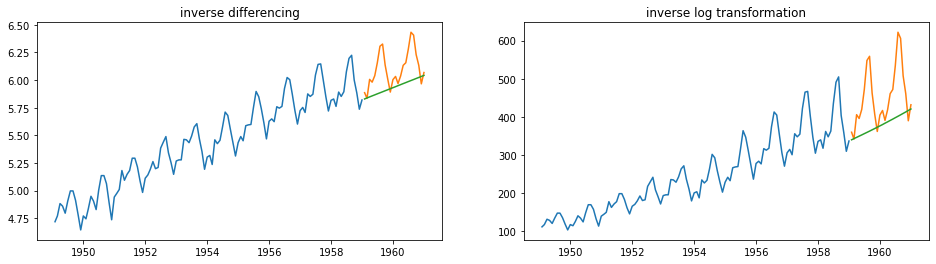

In [326]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 4))

ax1.plot(airpassengers_log_train)
ax1.plot(airpassengers_log_test)
ax1.plot(ses_forecast_inv_diff)
ax1.set_title('inverse differencing')

ax2.plot(airpassengers_ts_train)
ax2.plot(airpassengers_ts_test)
ax2.plot(ses_forecast_inv_log)
ax2.set_title('inverse log transformation')

# ARIMA

Since ARIMA does not works well with seasonality, we have to perform seasonal differencing to eliminate the seasonality in the data.

In [474]:
from statsmodels.tsa.arima_model import ARIMA

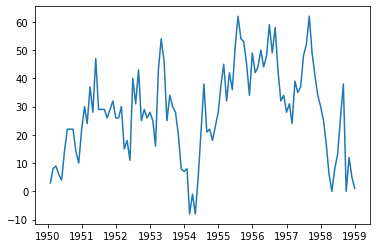

In [475]:
airpassengers_season_diff_train = airpassengers_ts_train.diff(12)
plt.plot(airpassengers_season_diff_train)

In [514]:
arima = ARIMA(airpassengers_season_diff_train.dropna(), order=(4,0,2)).fit()
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  108
Model:                     ARMA(4, 2)   Log Likelihood                -396.678
Method:                       css-mle   S.D. of innovations              9.308
Date:                Mon, 23 Mar 2020   AIC                            809.357
Time:                        15:32:04   BIC                            830.814
Sample:                    01-31-1950   HQIC                           818.057
                         - 12-31-1958                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.8860      5.354      4.835      0.000      15.393      36.379
ar.L1.y        0.8172      0.098      8.348      0.000       0.625       1.009
ar.L2.y       -0.7852      0.120     -6.563      0.000      -1.020      -0.551
ar.L3.y        0.4704      0.119      3.966      0.000       0.238       0.703
ar.L4.y        0.1950      0.098      1.988      0.047       0.003       0.387
ma.L1.y       -0.1335      0.030     -4.477      0.000      -0.192      -0.075
ma.L2.y        1.0000      0.050     19.888      0.000       0.901       1.099
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1699           -0.0000j            1.1699           -0.0000
AR.2            0.1274           -1.0612j            1.0688           -0.2310
AR.3            0.1274           +1.0612j            1.0688            0.2310
AR.4           -3.8373           -0.0000j            3.8373           -0.5000
MA.1            0.0668           -0.9978j            1.0000           -0.2394
MA.2            0.0668           +0.9978j            1.0000            0.2394
-----------------------------------------------------------------------------
"""

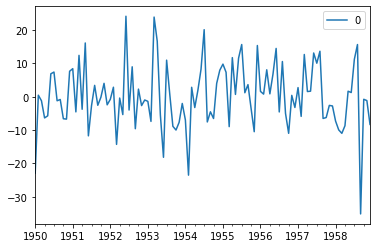

In [515]:
residuals = pd.DataFrame(arima.resid)
residuals.plot()

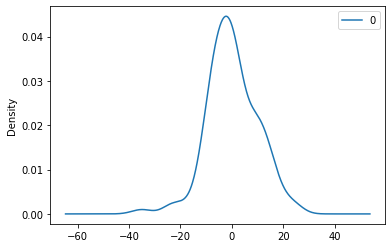

In [516]:
residuals.plot(kind='kde')

In [517]:
arima_forecast_raw = arima.forecast(24)
arima_forecast_ts = pd.Series(arima_forecast_raw[0], index=airpassengers_ts_test.index)

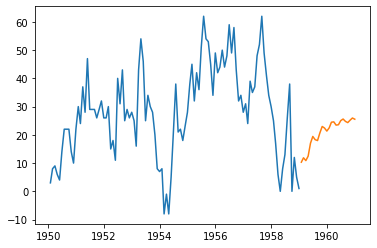

In [518]:
plt.plot(airpassengers_season_diff_train)
plt.plot(arima_forecast_ts)

In [519]:
airpassengers_season_diff_train

1949-01-31     NaN
1949-02-28     NaN
1949-03-31     NaN
1949-04-30     NaN
1949-05-31     NaN
              ... 
1958-08-31    38.0
1958-09-30     0.0
1958-10-31    12.0
1958-11-30     5.0
1958-12-31     1.0
Freq: M, Length: 120, dtype: float64

In [520]:
test= airpassengers_season_diff_train.copy()
test = test.append(arima_forecast_ts)

In [521]:

interval = 12
output = airpassengers_ts_train[:12].tolist()

[output.append(output[i-interval] + test[i]) for i in range(interval, len(test))]

output

[112,
 118,
 132,
 129,
 121,
 135,
 148,
 148,
 136,
 119,
 104,
 118,
 115.0,
 126.0,
 141.0,
 135.0,
 125.0,
 149.0,
 170.0,
 170.0,
 158.0,
 133.0,
 114.0,
 140.0,
 145.0,
 150.0,
 178.0,
 163.0,
 172.0,
 178.0,
 199.0,
 199.0,
 184.0,
 162.0,
 146.0,
 166.0,
 171.0,
 180.0,
 193.0,
 181.0,
 183.0,
 218.0,
 230.0,
 242.0,
 209.0,
 191.0,
 172.0,
 194.0,
 196.0,
 196.0,
 236.0,
 235.0,
 229.0,
 243.0,
 264.0,
 272.0,
 237.0,
 211.0,
 180.0,
 201.0,
 204.0,
 188.0,
 235.0,
 227.0,
 234.0,
 264.0,
 302.0,
 293.0,
 259.0,
 229.0,
 203.0,
 229.0,
 242.0,
 233.0,
 267.0,
 269.0,
 270.0,
 315.0,
 364.0,
 347.0,
 312.0,
 274.0,
 237.0,
 278.0,
 284.0,
 277.0,
 317.0,
 313.0,
 318.0,
 374.0,
 413.0,
 405.0,
 355.0,
 306.0,
 271.0,
 306.0,
 315.0,
 301.0,
 356.0,
 348.0,
 355.0,
 422.0,
 465.0,
 467.0,
 404.0,
 347.0,
 305.0,
 336.0,
 340.0,
 318.0,
 362.0,
 348.0,
 363.0,
 435.0,
 491.0,
 505.0,
 404.0,
 359.0,
 310.0,
 337.0,
 350.3153517757044,
 329.8707078596235,
 372.8779735397168,
 360

In [522]:
airpassengers_ts_train

1949-01-31    112
1949-02-28    118
1949-03-31    132
1949-04-30    129
1949-05-31    121
             ... 
1958-08-31    505
1958-09-30    404
1958-10-31    359
1958-11-30    310
1958-12-31    337
Freq: M, Length: 120, dtype: int64

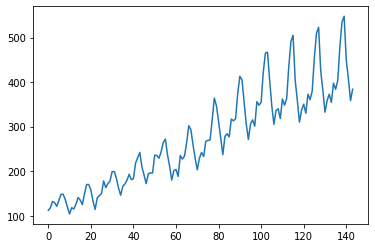

In [523]:
plt.plot(output)

In [470]:
len(output)

120

In [ ]:
def inverse_differencing(diff_series, interval, prev_series):
    

In [95]:
airpassengers_diff_train = airpassengers_diff[:-24]
airpassengers_diff_test = airpassengers_diff[-24:]

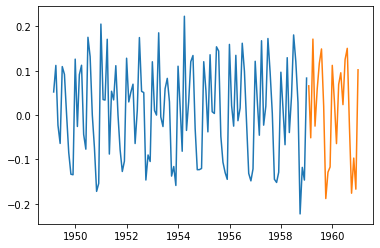

In [96]:
plt.plot(airpassengers_diff_train)
plt.plot(airpassengers_diff_test)

In [210]:
arima = ARIMA(airpassengers_diff[1:], order=(11,0,1)).fit()

/home/william/miniconda3/envs/main/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/william/miniconda3/envs/main/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [211]:
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  143
Model:                    ARMA(11, 1)   Log Likelihood                 226.623
Method:                       css-mle   S.D. of innovations              0.046
Date:                Mon, 23 Mar 2020   AIC                           -425.246
Time:                        12:18:30   BIC                           -383.766
Sample:                    02-28-1949   HQIC                          -408.391
                         - 12-31-1960                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0100      0.001     17.318      0.000       0.009       0.011
ar.L1.y       -0.8414      0.077    -10.973      0.000      -0.992      -0.691
ar.L2.y       -0.8027      0.060    -13.295      0.000      -0.921      -0.684
ar.L3.y       -0.7977      0.068    -11.667      0.000      -0.932      -0.664
ar.L4.y       -0.8734      0.051    -17.260      0.000      -0.973      -0.774
ar.L5.y       -0.7968      0.075    -10.626      0.000      -0.944      -0.650
ar.L6.y       -0.8036      0.067    -12.041      0.000      -0.934      -0.673
ar.L7.y       -0.7955      0.067    -11.949      0.000      -0.926      -0.665
ar.L8.y       -0.9114      0.045    -20.136      0.000      -1.000      -0.823
ar.L9.y       -0.8139      0.068    -12.002      0.000      -0.947      -0.681
ar.L10.y      -0.8382      0.059    -14.132      0.000      -0.954      -0.722
ar.L11.y      -0.7620      0.060    -12.705      0.000      -0.880      -0.644
ma.L1.y        0.4368      0.078      5.625      0.000       0.285       0.589
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1             0.8698           -0.4940j            1.0003           -0.0822
AR.2             0.8698           +0.4940j            1.0003            0.0822
AR.3             0.5066           -0.8737j            1.0100           -0.1664
AR.4             0.5066           +0.8737j            1.0100            0.1664
AR.5             0.0201           -1.0434j            1.0436           -0.2469
AR.6             0.0201           +1.0434j            1.0436            0.2469
AR.7            -0.5111           -0.8818j            1.0192           -0.3336
AR.8            -0.5111           +0.8818j            1.0192            0.3336
AR.9            -0.8923           -0.5002j            1.0230           -0.4187
AR.10           -0.8923           +0.5002j            1.0230            0.4187
AR.11           -1.0861           -0.0000j            1.0861           -0.5000
MA.1            -2.2893           +0.0000j            2.2893            0.5000
------------------------------------------------------------------------------
"""

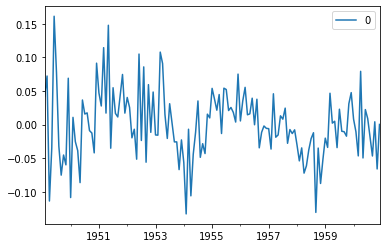

In [212]:
residuals = pd.DataFrame(arima.resid)
residuals.plot()

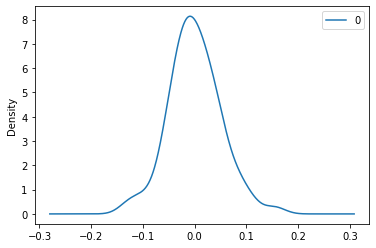

In [213]:
residuals.plot(kind='kde')

In [214]:
arima_forecast_raw = arima.forecast(24)
arima_forecast_ts = pd.Series(arima_forecast_raw[0], index=airpassengers_diff_test.index)

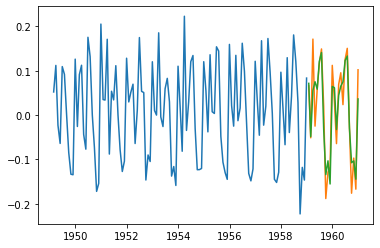

In [215]:
plt.plot(airpassengers_diff_train)
plt.plot(airpassengers_diff_test)
plt.plot(arima_forecast_ts)

In [216]:
arima_forecast_ts[0] = airpassengers_log[-25]
arima_forecast_inv_diff = arima_forecast_ts.cumsum()

arima_forecast_inv_log = np.exp(arima_forecast_inv_diff)

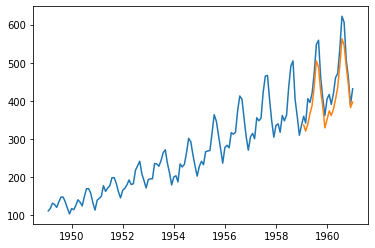

In [217]:
plt.plot(airpassengers_ts)
plt.plot(arima_forecast_inv_log)

In [218]:
arima_forecast_raw

(array([ 5.82008293, -0.04867971,  0.05593923,  0.07528109,  0.05836079,
         0.12121914,  0.14124727, -0.03221469, -0.1345278 , -0.10323068,
        -0.15555659,  0.06487121,  0.06157364, -0.03263792,  0.04445361,
         0.06525104,  0.07514499,  0.12292097,  0.13336191, -0.02950241,
        -0.10755893, -0.10347767, -0.14480499,  0.03639949]),
 array([0.04629104, 0.04993627, 0.05432766, 0.05446664, 0.05469971,
        0.05483891, 0.05483963, 0.0548438 , 0.05510508, 0.05532953,
        0.05533089, 0.055391  , 0.06573802, 0.06679119, 0.06873658,
        0.06903713, 0.06940664, 0.06952414, 0.06953402, 0.06954794,
        0.06996788, 0.07025787, 0.07026966, 0.07042241]),
 array([[-0.0191137 ,  0.16234385],
        [-0.146553  ,  0.04919357],
        [-0.05054102,  0.16241947],
        [-0.03147157,  0.18203375],
        [-0.04884866,  0.16557024],
        [ 0.01373685,  0.22870143],
        [ 0.03376358,  0.24873096],
        [-0.13970656,  0.07527718],
        [-0.24253177, -0.026

In [115]:
airpassengers_log

1949-01-31    4.718499
1949-02-28    4.770685
1949-03-31    4.882802
1949-04-30    4.859812
1949-05-31    4.795791
                ...   
1960-08-31    6.406880
1960-09-30    6.230481
1960-10-31    6.133398
1960-11-30    5.966147
1960-12-31    6.068426
Freq: M, Length: 144, dtype: float64

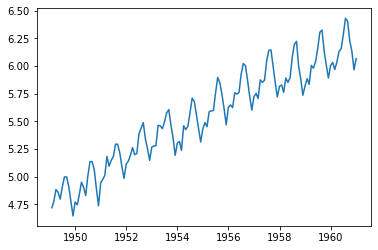

In [116]:
plt.plot(airpassengers_log)

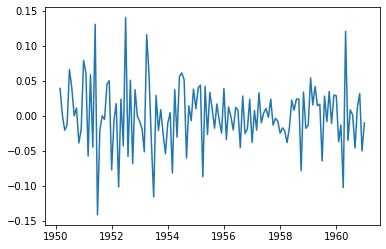

In [120]:
plt.plot(airpassengers_log.diff(periods=12).diff(periods=1))

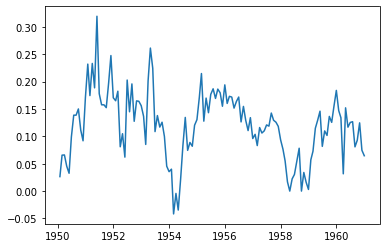

In [121]:
plt.plot(airpassengers_log.diff(periods=12))